In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

# Tamaño para las imágenes
IMAGE_SIZE = (128, 128)

# Cargar anotaciones
train_df = pd.read_csv('Dataset-SupermarketImages/annotations_multietiqueta.csv')
val_df = pd.read_csv('Dataset-SupermarketImages/annotations_val_multietiqueta.csv')

print(f"Datos de entrenamiento: {len(train_df)} muestras")
print(f"Datos de validación: {len(val_df)} muestras")
print(f"Clases: {list(train_df.columns[1:])}")

# Función para cargar imágenes
def load_images_and_labels(df, base_path='Dataset-SupermarketImages', image_size=IMAGE_SIZE):
    images = []
    labels = []
    failed_images = 0
    
    for idx, row in df.iterrows():
        img_path = os.path.join(base_path, row['image'])
        
        if not os.path.exists(img_path):
            failed_images += 1
            continue
            
        img = cv2.imread(img_path)
        if img is None:
            failed_images += 1
            continue
            
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        
        images.append(img)
        labels.append(row[1:].values.astype(np.float32))
    
    print(f"Imágenes cargadas: {len(images)} / {len(df)} (fallos: {failed_images})")
    
    return np.array(images), np.array(labels)

# Cargar datasets
x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)

print(f"\nFormas:")
print(f"X_train: {x_train.shape} - Y_train: {y_train.shape}")
print(f"X_val: {x_val.shape} - Y_val: {y_val.shape}")

# Verificar etiquetas
print(f"\nDistribución de etiquetas:")
for i, col in enumerate(train_df.columns[1:]):
    train_count = y_train[:, i].sum()
    val_count = y_val[:, i].sum()
    print(f"  {col}: train={int(train_count)}, val={int(val_count)}")


Datos de entrenamiento: 1080 muestras
Datos de validación: 61 muestras
Clases: ['Banana', 'Orange', 'Red-Bell-Pepper', 'aluminium-form', 'bread', 'cocaCola', 'doritos', 'red-bull', 'shampoo-H&S', 'tea', 'yogurt-toni-mix']
Imágenes cargadas: 1080 / 1080 (fallos: 0)
Imágenes cargadas: 1080 / 1080 (fallos: 0)
Imágenes cargadas: 61 / 61 (fallos: 0)

Formas:
X_train: (1080, 128, 128, 3) - Y_train: (1080, 11)
X_val: (61, 128, 128, 3) - Y_val: (61, 11)

Distribución de etiquetas:
  Banana: train=90, val=6
  Orange: train=90, val=5
  Red-Bell-Pepper: train=90, val=5
  aluminium-form: train=90, val=5
  bread: train=90, val=5
  cocaCola: train=180, val=9
  doritos: train=180, val=10
  red-bull: train=90, val=5
  shampoo-H&S: train=90, val=5
  tea: train=90, val=5
  yogurt-toni-mix: train=90, val=5
Imágenes cargadas: 61 / 61 (fallos: 0)

Formas:
X_train: (1080, 128, 128, 3) - Y_train: (1080, 11)
X_val: (61, 128, 128, 3) - Y_val: (61, 11)

Distribución de etiquetas:
  Banana: train=90, val=6
  Ora

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Obtener número de clases del dataset
num_classes = len(train_df.columns) - 1  # -1 por la columna 'image'
print(f"Número de clases: {num_classes}")
print(f"Clases: {list(train_df.columns[1:])}")

# Arquitectura simple y efectiva
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # sigmoid para multi-etiqueta
])

model.summary()


Número de clases: 11
Clases: ['Banana', 'Orange', 'Red-Bell-Pepper', 'aluminium-form', 'bread', 'cocaCola', 'doritos', 'red-bull', 'shampoo-H&S', 'tea', 'yogurt-toni-mix']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Compilación correcta para multi-etiqueta
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Cambio importante: binary_crossentropy para multi-etiqueta
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("Entrenando modelo con configuración multi-etiqueta...")
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)




Entrenando modelo con configuración multi-etiqueta...
Epoch 1/15
34/34 [==============================] - 10s 41ms/step - loss: 0.4508 - accuracy: 0.1083 - val_loss: 0.2668 - val_accuracy: 0.2131
Epoch 2/15
34/34 [==============================] - 10s 41ms/step - loss: 0.4508 - accuracy: 0.1083 - val_loss: 0.2668 - val_accuracy: 0.2131
Epoch 2/15
34/34 [==============================] - 1s 18ms/step - loss: 0.3205 - accuracy: 0.2852 - val_loss: 0.1765 - val_accuracy: 0.7213
Epoch 3/15
34/34 [==============================] - 1s 18ms/step - loss: 0.3205 - accuracy: 0.2852 - val_loss: 0.1765 - val_accuracy: 0.7213
Epoch 3/15
34/34 [==============================] - 1s 17ms/step - loss: 0.2334 - accuracy: 0.5120 - val_loss: 0.1301 - val_accuracy: 0.8197
Epoch 4/15
34/34 [==============================] - 1s 17ms/step - loss: 0.2334 - accuracy: 0.5120 - val_loss: 0.1301 - val_accuracy: 0.8197
Epoch 4/15
34/34 [==============================] - 1s 17ms/step - loss: 0.1991 - accuracy: 0.5870

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         5
           5       1.00      0.67      0.80         9
           6       1.00      0.60      0.75        10
           7       1.00      0.80      0.89         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5

   micro avg       1.00      0.82      0.90        65
   macro avg       1.00      0.84      0.90        65
weighted avg       1.00      0.82      0.89        65
 samples avg       0.87      0.84      0.85        65

              precision    recall  f1-score   support

           0       1.00    

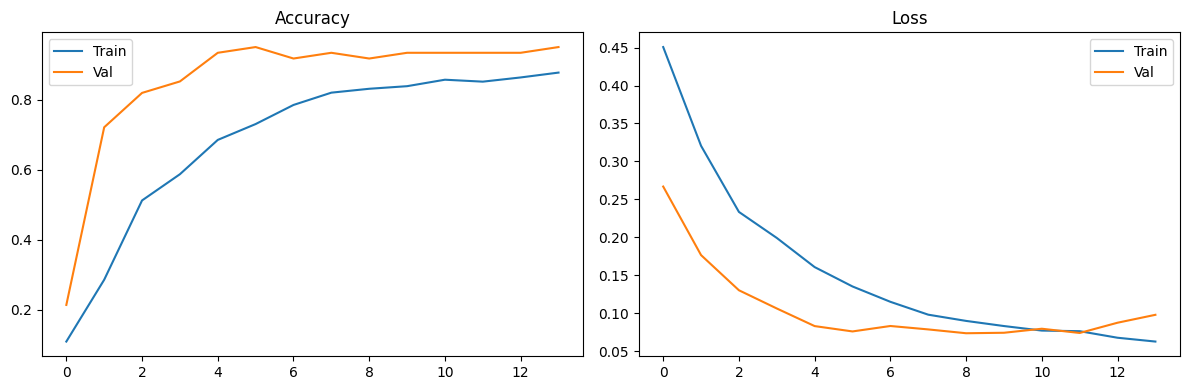

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Predicciones
y_pred = model.predict(x_val)
y_pred_bin = (y_pred > 0.5).astype(int)

# Reporte
print(classification_report(y_val, y_pred_bin, zero_division=0))

# Graficar entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


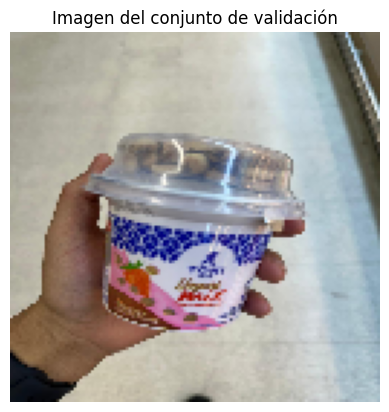

1/1 [==============================] - 0s 115ms/step
Etiquetas verdaderas:
['yogurt-toni-mix']

Etiquetas predichas:
['yogurt-toni-mix']
1/1 [==============================] - 0s 115ms/step
Etiquetas verdaderas:
['yogurt-toni-mix']

Etiquetas predichas:
['yogurt-toni-mix']


In [5]:
import random

idx = random.randint(0, len(x_val)-1)
img = x_val[idx]
true_labels = y_val[idx]

# Mostrar imagen
plt.imshow(img)
plt.axis('off')
plt.title("Imagen del conjunto de validación")
plt.show()

# Predicción
pred = model.predict(np.expand_dims(img, axis=0))[0]
pred_bin = (pred > 0.5).astype(int)

# Decodificar etiquetas
etiquetas = train_df.columns[1:]  # saltamos la columna 'image'
print("Etiquetas verdaderas:")
print([etiquetas[i] for i, v in enumerate(true_labels) if v == 1])

print("\nEtiquetas predichas:")
print([etiquetas[i] for i, v in enumerate(pred_bin) if v == 1])


1/1 [==============================] - 0s 18ms/step


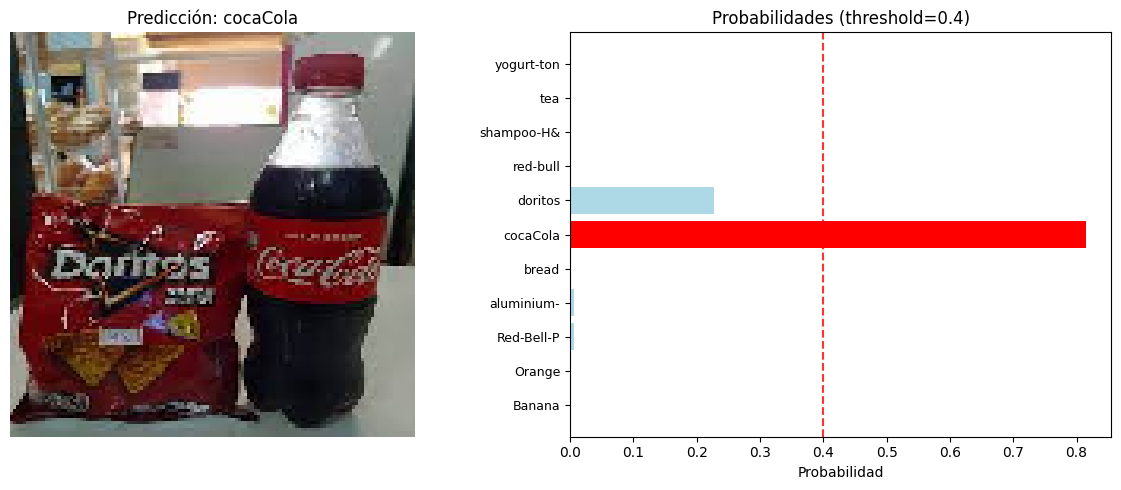

Clases detectadas (threshold 0.4): ['cocaCola']
Top-3 más probables:
   1. cocaCola: 0.815
   2. doritos: 0.227
   3. Red-Bell-Pepper: 0.007


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os

# === Definir imagen de prueba ===
imagen_prueba = 'C:\\Users\\Karen\\Documents\\Uni\\Sexto\\IA\\Practicas\\Proyecto\\Dataset-SupermarketImages\\Productos\\Validation\\doritos_cocaCola\\dorito_cocaCola_011.jpeg'  

# === Threshold óptimo ===
threshold_optimo = 0.4  

# === Función de predicción ===
def predecir_una_imagen(ruta_imagen, threshold=threshold_optimo):
    try:
        img_ext = load_img(ruta_imagen, target_size=IMAGE_SIZE)
        img_array = img_to_array(img_ext) / 255.0

        pred = model.predict(np.expand_dims(img_array, axis=0))[0]
        pred_bin = (pred > threshold).astype(int)
        etiquetas_detectadas = [etiquetas[i] for i, v in enumerate(pred_bin) if v == 1]

        top_indices = np.argsort(pred)[-3:][::-1]

        # Mostrar imagen y predicción
        plt.figure(figsize=(12, 5))

        # Imagen
        plt.subplot(1, 2, 1)
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f"Predicción: {', '.join(etiquetas_detectadas) if etiquetas_detectadas else 'Ninguna clase'}")

        # Gráfico de probabilidades
        plt.subplot(1, 2, 2)
        labels_short = [et[:10] for et in etiquetas]
        colors = ['red' if pred[i] > threshold else 'lightblue' for i in range(len(pred))]

        plt.barh(range(len(pred)), pred, color=colors)
        plt.yticks(range(len(pred)), labels_short, fontsize=9)
        plt.xlabel('Probabilidad')
        plt.title(f'Probabilidades (threshold={threshold})')
        plt.axvline(x=threshold, color='red', linestyle='--', alpha=0.8)
        plt.tight_layout()
        plt.show()

        print(f"Clases detectadas (threshold {threshold}): {etiquetas_detectadas if etiquetas_detectadas else 'Ninguna'}")
        print("Top-3 más probables:")
        for i, idx in enumerate(top_indices):
            print(f"   {i+1}. {etiquetas[idx]}: {pred[idx]:.3f}")

    except Exception as e:
        print(f"⚠️ Error al procesar la imagen: {e}")

# === Ejecutar predicción ===
predecir_una_imagen(imagen_prueba)


In [7]:
model.save('modelo_cnn_multietiqueta.h5')